<a href="https://colab.research.google.com/github/piaosan78/AIFFEL_Quest/blob/master/Exploration_CR5/Chapter_8/GAN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import time
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
(train_images, train_labels), (_, _) = cifar10.load_data()
train_images = train_images.astype('float32')

170498071/170498071 [==============================] - 6s 0us/step


In [2]:
train_images = (train_images - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화

In [3]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
NOISE_DIM = 100

In [6]:
# 2. 생성자와 판별자 모델 생성
def build_generator(noise_dim=100):
    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    # Transposed Convolution Layer 1
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed Convolution Layer 2
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed Convolution Layer 3
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

    return model

In [7]:
def build_discriminator():
    model = tf.keras.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Convolutional Layer 2
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# 모델 객체 생성
generator = build_generator()
discriminator = build_discriminator()

In [8]:
# 3. 손실 함수와 최적화 도구 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_labels_smoothed, real_output, fake_labels, fake_output):
    real_loss = cross_entropy(real_labels_smoothed, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
def add_gaussian_noise_to_input(input_tensor, mean=0., stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(input_tensor), mean=mean, stddev=stddev)
    return input_tensor + noise

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Add Gaussian noise to real and generated images
        images_with_noise = add_gaussian_noise_to_input(images)
        generated_images_with_noise = add_gaussian_noise_to_input(generated_images)

        real_output = discriminator(images_with_noise, training=True)
        fake_output = discriminator(generated_images_with_noise, training=True)

        # 레이블 스무딩 적용
        real_labels_smoothed = tf.ones_like(real_output) * 0.9
        fake_labels = tf.zeros_like(fake_output)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_labels_smoothed, real_output, fake_labels, fake_output)

        # Accuracy
        real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy


In [11]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}, Real Accuracy: {real_accuracy * 100}, Fake Accuracy: {fake_accuracy * 100}')

        # 15 에포크마다 생성된 이미지 저장
        if (epoch + 1) % 15 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # 마지막 에포크 후 생성된 이미지 저장
    generate_and_save_images(generator, epochs, seed)

In [12]:
# 5. 훈련 실행 및 가짜 이미지 시각화
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [13]:
# 훈련에 사용할 상수 설정
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

In [14]:
# 시각화를 위한 노이즈 벡터 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Epoch 1, Gen Loss: 2.0367636680603027, Disc Loss: 0.6552134156227112, Real Accuracy: 80.0, Fake Accuracy: 100.0
Time for epoch 1 is 26.468788623809814 sec
Epoch 2, Gen Loss: 1.1990742683410645, Disc Loss: 1.1820956468582153, Real Accuracy: 38.75, Fake Accuracy: 98.046875
Time for epoch 2 is 10.64436936378479 sec
Epoch 3, Gen Loss: 1.7626384496688843, Disc Loss: 0.7509311437606812, Real Accuracy: 83.75, Fake Accuracy: 100.0
Time for epoch 3 is 10.785359621047974 sec
Epoch 4, Gen Loss: 1.1755391359329224, Disc Loss: 1.3032763004302979, Real Accuracy: 46.25, Fake Accuracy: 84.375
Time for epoch 4 is 10.929795742034912 sec
Epoch 5, Gen Loss: 1.6136544942855835, Disc Loss: 1.0476117134094238, Real Accuracy: 61.25, Fake Accuracy: 89.453125
Time for epoch 5 is 11.11683440208435 sec
Epoch 6, Gen Loss: 1.915048360824585, Disc Loss: 0.9907320737838745, Real Accuracy: 58.749996185302734, Fake Accuracy: 93.359375
Time for epoch 6 is 1

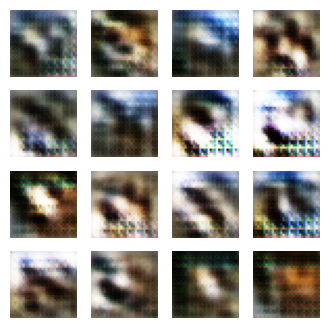

Time for epoch 15 is 12.455571413040161 sec
Epoch 16, Gen Loss: 1.7412149906158447, Disc Loss: 0.8163952231407166, Real Accuracy: 67.5, Fake Accuracy: 98.4375
Time for epoch 16 is 12.120617389678955 sec
Epoch 17, Gen Loss: 1.040394902229309, Disc Loss: 1.314845323562622, Real Accuracy: 47.5, Fake Accuracy: 87.890625
Time for epoch 17 is 12.176246166229248 sec
Epoch 18, Gen Loss: 1.2794342041015625, Disc Loss: 1.085301399230957, Real Accuracy: 43.75, Fake Accuracy: 98.828125
Time for epoch 18 is 12.130126953125 sec
Epoch 19, Gen Loss: 1.1781424283981323, Disc Loss: 1.2708779573440552, Real Accuracy: 41.25, Fake Accuracy: 89.84375
Time for epoch 19 is 12.031294345855713 sec
Epoch 20, Gen Loss: 1.5425865650177002, Disc Loss: 1.0863045454025269, Real Accuracy: 40.0, Fake Accuracy: 96.09375
Time for epoch 20 is 11.994840621948242 sec
Epoch 21, Gen Loss: 1.4456895589828491, Disc Loss: 1.0476775169372559, Real Accuracy: 52.499996185302734, Fake Accuracy: 93.75
Time for epoch 21 is 12.00358080

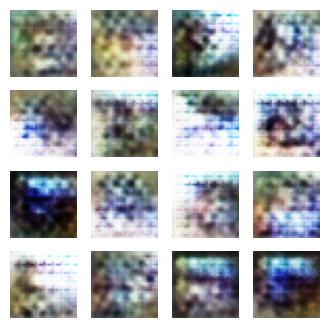

Time for epoch 30 is 12.702333211898804 sec
Epoch 31, Gen Loss: 1.200602650642395, Disc Loss: 1.351274013519287, Real Accuracy: 30.000001907348633, Fake Accuracy: 93.359375
Time for epoch 31 is 12.07737398147583 sec
Epoch 32, Gen Loss: 1.0645554065704346, Disc Loss: 1.1576623916625977, Real Accuracy: 45.0, Fake Accuracy: 95.3125
Time for epoch 32 is 12.093040704727173 sec
Epoch 33, Gen Loss: 1.1537156105041504, Disc Loss: 1.2688543796539307, Real Accuracy: 35.0, Fake Accuracy: 95.703125
Time for epoch 33 is 12.132419347763062 sec
Epoch 34, Gen Loss: 1.0905637741088867, Disc Loss: 1.1880807876586914, Real Accuracy: 40.0, Fake Accuracy: 90.625
Time for epoch 34 is 12.152538299560547 sec
Epoch 35, Gen Loss: 1.4125386476516724, Disc Loss: 1.0250582695007324, Real Accuracy: 56.25, Fake Accuracy: 94.53125
Time for epoch 35 is 12.110894918441772 sec
Epoch 36, Gen Loss: 1.7316161394119263, Disc Loss: 1.099305272102356, Real Accuracy: 58.749996185302734, Fake Accuracy: 89.84375
Time for epoch 3

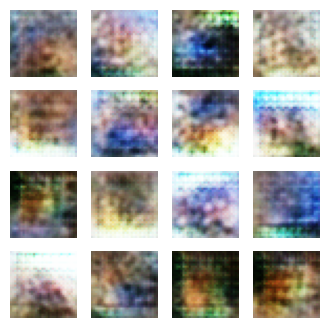

Time for epoch 45 is 12.55780816078186 sec
Epoch 46, Gen Loss: 1.368377685546875, Disc Loss: 1.0759122371673584, Real Accuracy: 50.0, Fake Accuracy: 96.09375
Time for epoch 46 is 12.122438907623291 sec
Epoch 47, Gen Loss: 1.3213450908660889, Disc Loss: 1.1684601306915283, Real Accuracy: 40.0, Fake Accuracy: 97.265625
Time for epoch 47 is 12.089021921157837 sec
Epoch 48, Gen Loss: 1.6285154819488525, Disc Loss: 1.0661052465438843, Real Accuracy: 45.0, Fake Accuracy: 99.609375
Time for epoch 48 is 12.111449241638184 sec
Epoch 49, Gen Loss: 1.2834607362747192, Disc Loss: 1.0412988662719727, Real Accuracy: 48.75, Fake Accuracy: 97.65625
Time for epoch 49 is 12.109716176986694 sec
Epoch 50, Gen Loss: 1.3273673057556152, Disc Loss: 1.0692888498306274, Real Accuracy: 57.5, Fake Accuracy: 93.75
Time for epoch 50 is 12.090896368026733 sec
Epoch 51, Gen Loss: 1.4100712537765503, Disc Loss: 1.0228480100631714, Real Accuracy: 42.5, Fake Accuracy: 97.65625
Time for epoch 51 is 12.135465860366821 se

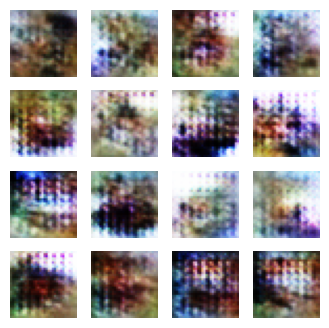

Time for epoch 60 is 12.518349885940552 sec
Epoch 61, Gen Loss: 1.2032164335250854, Disc Loss: 1.2870190143585205, Real Accuracy: 45.0, Fake Accuracy: 86.328125
Time for epoch 61 is 12.111871242523193 sec
Epoch 62, Gen Loss: 1.0653411149978638, Disc Loss: 1.3450160026550293, Real Accuracy: 35.0, Fake Accuracy: 92.1875
Time for epoch 62 is 12.097365856170654 sec
Epoch 63, Gen Loss: 1.0607998371124268, Disc Loss: 1.3777098655700684, Real Accuracy: 32.5, Fake Accuracy: 88.28125
Time for epoch 63 is 12.092989206314087 sec
Epoch 64, Gen Loss: 1.2633752822875977, Disc Loss: 1.143306016921997, Real Accuracy: 40.0, Fake Accuracy: 94.921875
Time for epoch 64 is 12.090087652206421 sec
Epoch 65, Gen Loss: 1.3852779865264893, Disc Loss: 1.0987017154693604, Real Accuracy: 52.499996185302734, Fake Accuracy: 93.75
Time for epoch 65 is 12.086891889572144 sec
Epoch 66, Gen Loss: 1.6641825437545776, Disc Loss: 0.9473062753677368, Real Accuracy: 47.5, Fake Accuracy: 97.265625
Time for epoch 66 is 12.0874

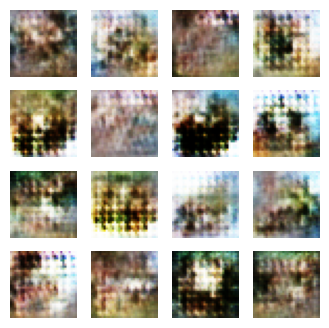

Time for epoch 75 is 12.741240978240967 sec
Epoch 76, Gen Loss: 1.1945126056671143, Disc Loss: 1.2917401790618896, Real Accuracy: 37.5, Fake Accuracy: 90.234375
Time for epoch 76 is 12.108116149902344 sec
Epoch 77, Gen Loss: 1.1715723276138306, Disc Loss: 1.1352033615112305, Real Accuracy: 48.75, Fake Accuracy: 91.796875
Time for epoch 77 is 12.102592706680298 sec
Epoch 78, Gen Loss: 1.3782875537872314, Disc Loss: 1.1150460243225098, Real Accuracy: 45.0, Fake Accuracy: 96.09375
Time for epoch 78 is 12.133082389831543 sec
Epoch 79, Gen Loss: 1.3065484762191772, Disc Loss: 1.1553869247436523, Real Accuracy: 42.5, Fake Accuracy: 91.015625
Time for epoch 79 is 12.14972472190857 sec
Epoch 80, Gen Loss: 1.0004312992095947, Disc Loss: 1.2710034847259521, Real Accuracy: 38.75, Fake Accuracy: 92.96875
Time for epoch 80 is 12.139991044998169 sec
Epoch 81, Gen Loss: 1.072249174118042, Disc Loss: 1.369886875152588, Real Accuracy: 30.000001907348633, Fake Accuracy: 87.109375
Time for epoch 81 is 12

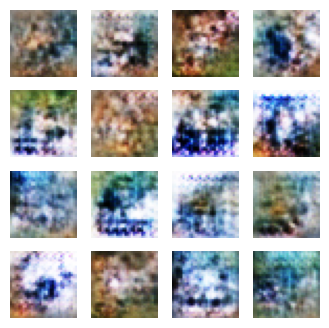

Time for epoch 90 is 12.440685033798218 sec
Epoch 91, Gen Loss: 1.2785224914550781, Disc Loss: 1.1545155048370361, Real Accuracy: 45.0, Fake Accuracy: 92.578125
Time for epoch 91 is 12.06747317314148 sec
Epoch 92, Gen Loss: 1.0460506677627563, Disc Loss: 1.2893553972244263, Real Accuracy: 36.25, Fake Accuracy: 90.625
Time for epoch 92 is 12.077160120010376 sec
Epoch 93, Gen Loss: 1.3012356758117676, Disc Loss: 1.098825454711914, Real Accuracy: 40.0, Fake Accuracy: 94.53125
Time for epoch 93 is 12.076903820037842 sec
Epoch 94, Gen Loss: 1.1998509168624878, Disc Loss: 1.2258139848709106, Real Accuracy: 35.0, Fake Accuracy: 91.40625
Time for epoch 94 is 12.080924987792969 sec
Epoch 95, Gen Loss: 1.2659225463867188, Disc Loss: 1.0467846393585205, Real Accuracy: 51.25, Fake Accuracy: 96.875
Time for epoch 95 is 12.084333181381226 sec
Epoch 96, Gen Loss: 1.1203171014785767, Disc Loss: 1.291426420211792, Real Accuracy: 36.25, Fake Accuracy: 91.40625
Time for epoch 96 is 12.084197044372559 sec

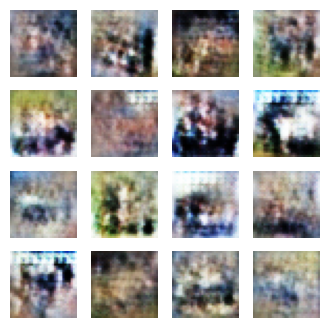

In [15]:
# GAN 훈련
%time
train(train_dataset, EPOCHS)

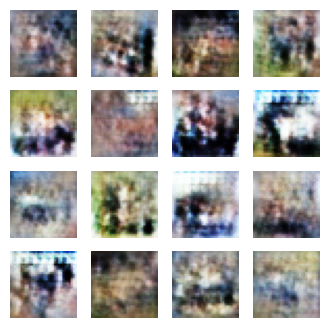

In [18]:
# 마지막 훈련 에폭 후 생성된 이미지 시각화
generate_and_save_images(generator, EPOCHS, seed)

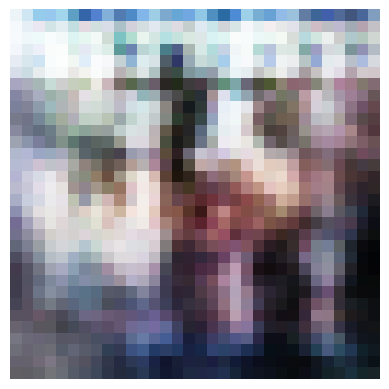

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

# 생성자를 사용하여 이미지 생성
generated_image = generator(noise, training=False)

# 생성된 이미지 시각화
plt.imshow((generated_image[0, :, :, :] + 1) / 2.0)  # [-1, 1] 범위를 [0, 1]로 변경
plt.axis('off')
plt.show()
